# Imports

In [75]:
# Python imports
import sys,os
import numpy as np
import pylab as py
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy.special as spec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"
matplotlib.rc('text',usetex=True)

In [76]:
# Own .py file imports
import mceg
from tools import load, save, checkdir,lprint

# Auxiliary definitions

In [77]:
# Define location of storage folders for large npy arrays
localfile='/home/astrid/Documents/WorkBackup/g2ppipiLab/Storage/'

In [78]:
# Constants
Mp = 0.93827
Mpi = 0.1395

In [79]:
# Auxiliary function for histogram generation
def get_xy_steps(xbins,yvalues):
    X,Y=[],[]
    for i in range(len(xbins)-1):
        x1=xbins[i]
        x2=xbins[i+1]
        y=yvalues[i]            
        X.append(x1)
        Y.append(y)
        X.append(x2)
        Y.append(y)
    return np.array(X),np.array(Y) 

In [80]:
# Auxiliary functions for manipulation of arrays of 4-vectors
def dot(A,B):
    return A[0]*B[0] - A[1]*B[1] - A[2]*B[2] - A[3]*B[3]

def dot3(A,B):
    return A[1]*B[1] + A[2]*B[2] + A[3]*B[3]

def add(A,B):
    ApB={}
    ApB[0]=A[0]+B[0] 
    ApB[1]=A[1]+B[1] 
    ApB[2]=A[2]+B[2] 
    ApB[3]=A[3]+B[3] 
    return ApB

def sub(A,B):
    AmB={}
    AmB[0]=A[0]-B[0] 
    AmB[1]=A[1]-B[1] 
    AmB[2]=A[2]-B[2] 
    AmB[3]=A[3]-B[3] 
    return AmB

def get_3mom_sqr(p):
    return p[1]*p[1]+p[2]*p[2]+p[3]*p[3]

In [81]:
# Auxiliary functions for transformations between lab, CM frames and description with invariants.
# Currently they are not being used, since this is a notebook concerned only about lab frame.
def rot_phi(p,phi):
    pr = {}
    pr[0]=p[0]
    pr[1]=p[1]*np.cos(phi)-p[2]*np.sin(phi)
    pr[2]=p[2]*np.cos(phi)+p[1]*np.sin(phi)
    pr[3]=p[3]
    return pr

def rot_theta(p,theta):
    pr = {}
    pr[0] = p[0]
    pr[1] = p[1]*np.cos(theta)+p[3]*np.sin(theta)
    pr[2] = p[2]
    pr[3] = p[3]*np.cos(theta)-p[1]*np.sin(theta)
    return pr

def get_phi(p):
    atan=np.arctan2(p[2],p[1])
    index=np.where(atan<0)
    atan[index]+=2.*np.pi
    return atan

def get_alpha(pip,pim):
    N=len(pip[0])
    ez={}
    ez[1]=np.zeros(N)
    ez[2]=np.zeros(N)
    ez[3]=np.ones(N)
    nnp={}
    nnp[1]=pip[1]/np.sqrt(get_3mom_sqr(pip))
    nnp[2]=pip[2]/np.sqrt(get_3mom_sqr(pip))
    nnp[3]=pip[3]/np.sqrt(get_3mom_sqr(pip))
    nnm={}
    nnm[1]=pim[1]/np.sqrt(get_3mom_sqr(pim))
    nnm[2]=pim[2]/np.sqrt(get_3mom_sqr(pim))
    nnm[3]=pim[3]/np.sqrt(get_3mom_sqr(pim))
    aa=np.ones(N)/np.sqrt(np.ones(N)-dot3(ez,nnp)**2)
    ba=dot3(ez,nnp)*aa
    ab=np.ones(N)/np.sqrt(np.ones(N)-dot3(nnm,nnp)**2)
    bb=-dot3(nnm,nnp)*ab
    gamma={}
    beta={}
    delta={}
    gamma[1]=-aa*ez[1]+ba*nnp[1]
    gamma[2]=-aa*ez[2]+ba*nnp[2]
    gamma[3]=-aa*ez[3]+ba*nnp[3]
    beta[1]=ab*nnm[1]+bb*nnp[1]
    beta[2]=ab*nnm[2]+bb*nnp[2]
    beta[3]=ab*nnm[3]+bb*nnp[3]
    delta[1]=gamma[2]*beta[3]-gamma[3]*beta[2]
    delta[2]=gamma[3]*beta[1]-gamma[1]*beta[3]
    delta[3]=gamma[1]*beta[2]-gamma[2]*beta[1]
    prob=dot3(delta,nnp)
    alpha=np.where(prob>=0,np.arccos(dot3(gamma,beta)),2.*np.pi*np.ones(N)-np.arccos(dot3(gamma,beta)))
    return alpha

In [82]:
# Transformations between variables in different frames
def com_to_lab(pcm,s):
    plab = {}
    plab[0] = (Mp**2+s)/(2.*Mp*np.sqrt(s))*pcm[0] + (-Mp**2+s)/(2.*Mp*np.sqrt(s))*pcm[3]
    plab[1]=pcm[1]
    plab[2]=pcm[2]
    plab[3] = (-Mp**2+s)/(2.*Mp*np.sqrt(s))*pcm[0] + (Mp**2+s)/(2.*Mp*np.sqrt(s))*pcm[3]
    return plab

def lab_to_com(plab,s):
    pcm = {}
    pcm[0] = (Mp**2+s)/(2.*Mp*np.sqrt(s))*plab[0] + (Mp**2-s)/(2.*Mp*np.sqrt(s))*plab[3]
    pcm[1]=plab[1]
    pcm[2]=plab[2]
    pcm[3] = (Mp**2-s)/(2.*Mp*np.sqrt(s))*plab[0] + (Mp**2+s)/(2.*Mp*np.sqrt(s))*plab[3]
    return pcm

def inv_to_com(s,sppim,spipm,tpip,phi,alpha,MX):
    N=len(s)
    ome=(s-Mp**2*np.ones(N))/(2.*np.sqrt(s))
    ep1=np.sqrt(Mp**2*np.ones(N)+ome**2)
    epip=(s+Mpi**2*np.ones(N)-sppim)/(2.*np.sqrt(s))
    ppip=np.sqrt(epip**2-Mpi**2*np.ones(N))
    ep2=(s+Mp**2*np.ones(N)-spipm)/(2.*np.sqrt(s))
    pp2=np.sqrt(ep2**2-Mp**2*np.ones(N))
    epim=ome+ep1-ep2-epip
    ppim=np.sqrt(epim**2-MX**2)
    sppip=s+MX**2-2.*np.sqrt(s)*epim
    thpip=np.arccos((tpip+2.*ome*epip-Mpi**2*np.ones(N))/(2.*ome*ppip))
    phpimp=alpha
    php2p=np.where(alpha < np.pi,alpha+np.pi*np.ones(N),alpha-np.pi*np.ones(N))
    thpimp=np.arccos((Mpi**2*np.ones(N)+MX**2+2.*epip*epim-spipm)/(2.*ppip*ppim))
    thp2p=np.arccos((Mpi**2*np.ones(N)+Mp**2*np.ones(N)+2.*epip*ep2-sppip)/(2.*ppip*pp2))
    beam={}
    targ={}
    p2={}
    pim={}
    pip={}
    p2p={}
    pimp={}
    pipp={}
    beam[0]=ome
    beam[1]=np.zeros(N)
    beam[2]=np.zeros(N)
    beam[3]=ome
    targ[0]=ep1
    targ[1]=np.zeros(N)
    targ[2]=np.zeros(N)
    targ[3]=-ome
    pipp[0]=epip
    pipp[1]=np.zeros(N)
    pipp[2]=np.zeros(N)
    pipp[3]=ppip
    pimp[0]=epim
    pimp[1]=ppim*np.sin(thpimp)*np.cos(phpimp)
    pimp[2]=ppim*np.sin(thpimp)*np.sin(phpimp)
    pimp[3]=ppim*np.cos(thpimp)
    p2p[0]=ep2
    p2p[1]=pp2*np.sin(thp2p)*np.cos(php2p)
    p2p[2]=pp2*np.sin(thp2p)*np.sin(php2p)
    p2p[3]=pp2*np.cos(thp2p)
    pip=rot_phi(rot_theta(pipp,thpip),phi)
    pim=rot_phi(rot_theta(pimp,thpip),phi)
    p2=rot_phi(rot_theta(p2p,thpip),phi)
    return beam,targ,pim,pip,p2

# Generating Ylm's from GAN events

In [83]:
# This generates lab-frame GAN events and stores the information needed from them:
# Ylm's, invariants and some other variables
def gen_Ylm(nsamples=1000):
    evts=mceg.gen_samples(nsamples)
    samples=evts.T
    MX2=samples[0]
    N = len(MX2)
    nu=samples[1]
    rec={}
    rec[0]=samples[11]
    rec[1]=samples[2]
    rec[2]=samples[5]
    rec[3]=samples[8]
    pip={} 
    pip[0]=samples[12]
    pip[1]=samples[3]
    pip[2]=samples[6]
    pip[3]=samples[9]
    pim={}
    pim[0]=samples[13]
    pim[1]=samples[4]
    pim[2]=samples[7]
    pim[3]=samples[10]
    beam={}
    beam[0]=nu
    beam[1]=np.zeros(N)
    beam[2]=np.zeros(N)
    beam[3]=nu
    targ={}
    targ[0]=Mp*np.ones(N)
    targ[1]=np.zeros(N)
    targ[2]=np.zeros(N)
    targ[3]=np.zeros(N)
    
    Mpipi=np.sqrt(dot(add(pim,pip),add(pim,pip)))  
    s=dot(add(targ,beam),add(targ,beam))
    spipm=dot(add(pip,pim),add(pip,pim))
    sppip=dot(add(rec,pip),add(rec,pip))
    sppim=dot(add(rec,pim),add(rec,pim))
    t=dot(sub(targ,rec),sub(targ,rec))
    tpip=dot(sub(beam,pip),sub(beam,pip))
    tpim=dot(sub(beam,pim),sub(beam,pim))
    
    
    # Gottfried-Jackson frame (c.o.m. frame of the pi+ pi- system)
    eg = (spipm-t)/(2.0*np.sqrt(spipm))
    ep1 = (s+t-Mp**2*np.ones(N))/(2.0*np.sqrt(spipm))
    ep2 = (s-spipm-Mp**2*np.ones(N))/(2.0*np.sqrt(spipm))
    epip = np.sqrt(spipm)/2.0
    epim = np.sqrt(spipm)/2.0
    mompi = np.sqrt(epip**2-Mpi**2*np.ones(N))
    momrecsqr=ep2**2-Mp**2*np.ones(N)
    
    Complex=lambda a,b: a+complex(0,1)*b
    momrec=np.sqrt(Complex(momrecsqr,0.))
    
    
    costheta=(sppip-Mp**2*np.ones(N)-Mpi**2*np.ones(N)-2.0*ep2*epip)/(2.0*momrec*mompi)
    cosq=(t-2.0*ep2**2+2.0*ep1*ep2)/(2.0*eg*momrec)
    sintheta=np.sin(np.arccos(costheta))
    sinq=np.sin(np.arccos(cosq))
    cosphi=(tpim-Mpi**2*np.ones(N)+eg*np.sqrt(spipm))/(2.0*eg*mompi*sinq*sintheta)+costheta/sintheta*cosq/sinq
    sinphi=np.sin(np.arccos(cosphi))
    
    angs={}
    angs[0]=costheta
    angs[1]=sintheta
    angs[2]=cosphi
    angs[3]=sinphi
    
    Ylm={}    
    Ylm[0]={}
    Ylm[0][0]=2.0*np.sqrt(np.pi)*0.5/np.sqrt(np.pi)*np.ones(N)
    Ylm[1]={}
    Ylm[1][-1]=2.0*np.sqrt(np.pi)*0.5*np.sqrt(1.5/np.pi)*Complex(angs[2],-angs[3])*angs[1]
    Ylm[1][0]=2.0*np.sqrt(np.pi)*0.5*np.sqrt(1.5/np.pi)*angs[0]
    Ylm[1][1]=-2.0*np.sqrt(np.pi)*0.5*np.sqrt(1.5/np.pi)*Complex(angs[2],angs[3])*angs[1]
    Ylm[2]={}
    Ylm[2][-2]=2.0*np.sqrt(np.pi)*0.25*np.sqrt(7.5/np.pi)*Complex(2.0*angs[2],-2.0*angs[3])*angs[1]**2
    Ylm[2][-1]=2.0*np.sqrt(np.pi)*0.5*np.sqrt(7.5/np.pi)*Complex(angs[2],-angs[3])*angs[1]*angs[0]
    Ylm[2][0]=2.0*np.sqrt(np.pi)*0.25*np.sqrt(5.0/np.pi)*(3.0*angs[0]**2-1.0)
    Ylm[2][1]=-2.0*np.sqrt(np.pi)*0.5*np.sqrt(7.5/np.pi)*Complex(angs[2],angs[3])*angs[1]*angs[0]
    Ylm[2][2]=2.0*np.sqrt(np.pi)*0.25*np.sqrt(7.5/np.pi)*Complex(2.0*angs[2],2.0*angs[3])*angs[1]**2
    Ylm[3]={}
    Ylm[3][-3]=2.0*np.sqrt(np.pi)*0.125*np.sqrt(35./np.pi)*Complex(3.0*angs[2],-3.0*angs[3])*angs[1]**3
    Ylm[3][-2]=2.0*np.sqrt(np.pi)*0.25*np.sqrt(52.5/np.pi)*Complex(2.0*angs[2],-2.0*angs[3])*angs[1]**2*angs[0]
    Ylm[3][-1]=2.0*np.sqrt(np.pi)*0.125*np.sqrt(21./np.pi)*Complex(angs[2],-angs[3])*angs[1]*(5.0*angs[0]**2-1.0)
    Ylm[3][0]=2.0*np.sqrt(np.pi)*0.25*np.sqrt(7./np.pi)*angs[0]*(5.0*angs[0]**2-3.0)
    Ylm[3][1]=-2.0*np.sqrt(np.pi)*0.125*np.sqrt(21./np.pi)*Complex(angs[2],angs[3])*angs[1]*(5.0*angs[0]**2-1.0)
    Ylm[3][2]=2.0*np.sqrt(np.pi)*0.25*np.sqrt(52.5/np.pi)*Complex(2.0*angs[2],2.0*angs[3])*angs[1]**2*angs[0]
    Ylm[3][3]=-2.0*np.sqrt(np.pi)*0.125*np.sqrt(35./np.pi)*Complex(3.0*angs[2],3.0*angs[3])*angs[1]**3
    Ylm[4]={}
    Ylm[4][-4]=2.0*np.sqrt(np.pi)*3.0/16.0*np.sqrt(17.5/np.pi)*Complex(4.0*angs[2],-4.0*angs[3])*angs[1]**4
    Ylm[4][-3]=2.0*np.sqrt(np.pi)*3.0/8.0*np.sqrt(35./np.pi)*Complex(3.0*angs[2],-3.0*angs[3])*angs[1]**3*angs[0]
    Ylm[4][-2]=2.0*np.sqrt(np.pi)*3.0/8.0*np.sqrt(2.5/np.pi)*Complex(2.0*angs[2],-2.0*angs[3])*angs[1]**2*(7.*angs[0]**2-1.)
    Ylm[4][-1]=2.0*np.sqrt(np.pi)*3.0/8.0*np.sqrt(5./np.pi)*Complex(angs[2],-angs[3])*angs[1]*(7.*angs[0]**3-3.*angs[0])
    Ylm[4][0]=2.0*np.sqrt(np.pi)*3.0/16.0*np.sqrt(1./np.pi)*(35.*angs[0]**4-30.*angs[0]**2+3.)
    Ylm[4][1]=-2.0*np.sqrt(np.pi)*3.0/8.0*np.sqrt(5./np.pi)*Complex(angs[2],angs[3])*angs[1]*(7.*angs[0]**3-3.*angs[0])
    Ylm[4][2]=2.0*np.sqrt(np.pi)*3.0/8.0*np.sqrt(2.5/np.pi)*Complex(2.0*angs[2],2.0*angs[3])*angs[1]**2*(7.*angs[0]**2-1.)
    Ylm[4][3]=-2.0*np.sqrt(np.pi)*3.0/8.0*np.sqrt(35./np.pi)*Complex(3.0*angs[2],3.0*angs[3])*angs[1]**3*angs[0]
    Ylm[4][4]=2.0*np.sqrt(np.pi)*3.0/16.0*np.sqrt(17.5/np.pi)*Complex(4.0*angs[2],4.0*angs[3])*angs[1]**4
    ganevents=Ylm,MX2,nu,costheta,cosphi,t,Mpipi,s,spipm,sppip,sppim,tpip,tpim
    checkdir(localfile+'./evtsnpy')  
    np.save(localfile+'./evtsnpy/Ylm_evts-lab.npy', ganevents)

# This generates the data for histogram plotting of the GAN events.
# Choice of which Ylm (l=?,m=?), which invariant (e.g. 't'), and in which range of this invariant
# (e.g. if for tmin and tmax the values 4 and 5 are chosen, this means the range is from -.5 to -.4 GeV^2)
def gen_hist_Ylm(ll,mm, inv, manmin,manmax, bins = 100,rand=100,bootsamp=100):
    ganevents=np.load(localfile+'./evtsnpy/Ylm_evts-lab.npy',allow_pickle=True)
    Ylm,MX2,nu,costheta,cosphi,t,Mpipi,s,spipm,sppip,sppim,tpip,tpim=ganevents
    if inv=='t':
        fininv=t
        finmin=-manmax
        finmax=-manmin
    elif inv=='s':
        fininv=s
        finmin=manmin
        finmax=manmax
    elif inv=='spipm':
        fininv=spipm
        finmin=manmin
        finmax=manmax
    elif inv=='sppip':
        fininv=sppip
        finmin=manmin
        finmax=manmax
    elif inv=='sppim':
        fininv=sppim
        finmin=manmin
        finmax=manmax
    elif inv=='tpip':
        fininv=tpip
        finmin=-manmax
        finmax=-manmin
    elif inv=='tpim':
        fininv=tpim
        finmin=-manmax
        finmax=-manmin
    I=[i for i in range(MX2.size) if (3.8>nu[i]>3.0 and abs(MX2[i]-0.019)<0.06 and -1.0<=costheta[i]<=1.0 and -1.0<=cosphi[i]<=1.0 and finmin/10.<=fininv[i]<=finmax/10.)]
    Mpipi=Mpipi[I]
    YLM=np.real(Ylm[ll][mm][I])
    cnt=len(Mpipi)
    print(cnt)
    Rpipi=(0.4,1.4)
    Y=[]
    
    for k in range(rand):    
# This commented-out part was Nobuo's suggestion for bootstrapping;
# however, I think that with this method the sample being generated is always the same,
# i.e. the full array of Mpipi in its complete length=cnt.

#        H,E=np.histogram(np.random.choice(Mpipi,cnt,replace=True),range=Rpipi,bins=bins,weights=YLM)
#        x,y=get_xy_steps(E,H/cnt)

        
# In the following, comes Astrid's suggestion for bootstrapping:
# from the array of integers [0,1,2,...,cnt], a random subset of these integers is chosen, with size=bootsamp;
# from the arrays Mpipi and YLM, a subset is taken of those array elements corresponding to the subset of integers;
# a histogram is generated from those (due to the for loop above, this is then done n=rand times).
        subset=np.random.choice(np.arange(cnt),bootsamp,replace=True)
        Mpipisubs=Mpipi[subset]
        YLMsubs=YLM[subset]
        H,E=np.histogram(Mpipisubs,range=Rpipi,bins=bins,weights=YLMsubs)
        x,y=get_xy_steps(E,H/bootsamp)
        Y.append(y)
# End of substitution
        
    avy=np.mean(Y,axis=0)
    dy=np.std(Y,axis=0)
    data={}
    data['X']=x
    data['Y']=avy
    data['dY']=dy #--statistical uncertainties
    data['Ymin']=avy-dy
    data['Ymax']=avy+dy
    checkdir(localfile+'data')
    save(data,localfile+'data/Y'+str(ll)+str(mm)+'-gan-lab-'+inv+'-'+str(manmin)+'-'+str(manmax)+'.po')
    return

# Generating Ylm's from CLAS data

In [84]:
# This stores the information from CLAS data:
# Ylm's, invariants and some other variables
def dat_Ylm():  
    F=os.listdir('/home/astrid/Documents/WorkBackup/g2ppipiLab/clascorrsplit1/')
    samplestp={}
    fulllen=0
    for i in range(len(F)):
        f=F[i]
        samplestp[i]=np.load('/home/astrid/Documents/WorkBackup/g2ppipiLab/clascorrsplit1/%s'%f).T 
        fulllen+=len(samplestp[i][0])
    samples={}
    for j in range(14):
        samples[j]=np.zeros(fulllen)
        start=0
        end=len(samplestp[0][j])
        samples[j][start:end]=samplestp[0][j]
        for i in range(1,len(F)):
            start+=len(samplestp[i-1][j])
            end+=len(samplestp[i][j])
            samples[j][start:end]=samplestp[i][j]
        
        
    MX2=samples[0]
    N = len(MX2)
    nu=samples[1]
    rec={}
    rec[0]=samples[11]
    rec[1]=samples[2]
    rec[2]=samples[5]
    rec[3]=samples[8]
    pip={} 
    pip[0]=samples[12]
    pip[1]=samples[3]
    pip[2]=samples[6]
    pip[3]=samples[9]
    pim={}
    pim[0]=samples[13]
    pim[1]=samples[4]
    pim[2]=samples[7]
    pim[3]=samples[10]
    beam={}
    beam[0]=nu
    beam[1]=np.zeros(N)
    beam[2]=np.zeros(N)
    beam[3]=nu
    targ={}
    targ[0]=Mp*np.ones(N)
    targ[1]=np.zeros(N)
    targ[2]=np.zeros(N)
    targ[3]=np.zeros(N)

    ptheta=np.arctan2(rec[1],rec[2])
    ptheta=ptheta.reshape(-1,1)
    piptheta=np.arctan2(pip[1],pip[2])
    piptheta=piptheta.reshape(-1,1)
    theta=np.concatenate([ptheta,piptheta],axis=1)
    theta=np.floor(theta/np.pi*180.+205.)%60
    index=np.where((theta[:,0]<=50)&(theta[:,1]<=50))
    for i in range(len(samples)):
        samples[i]=samples[i][index]
        
    Mpipi=np.sqrt(dot(add(pim,pip),add(pim,pip)))  
    s=dot(add(targ,beam),add(targ,beam))
    spipm=dot(add(pip,pim),add(pip,pim))
    sppip=dot(add(rec,pip),add(rec,pip))
    sppim=dot(add(rec,pim),add(rec,pim))
    t=dot(sub(targ,rec),sub(targ,rec))
    tpip=dot(sub(beam,pip),sub(beam,pip))
    tpim=dot(sub(beam,pim),sub(beam,pim))
    
    
    # Gottfried-Jackson frame (c.o.m. frame of the pi+ pi- system)
    eg = (spipm-t)/(2.0*np.sqrt(spipm))
    ep1 = (s+t-Mp**2*np.ones(N))/(2.0*np.sqrt(spipm))
    ep2 = (s-spipm-Mp**2*np.ones(N))/(2.0*np.sqrt(spipm))
    epip = np.sqrt(spipm+Mpi**2*np.ones(N)-MX2)/2.0
    epim = np.sqrt(spipm-Mpi**2*np.ones(N)+MX2)/2.0
    mompi = np.sqrt(epip**2-Mpi**2*np.ones(N))
    momrecsqr=ep2**2-Mp**2*np.ones(N)
    
    Complex=lambda a,b: a+complex(0,1)*b
    momrec=np.sqrt(Complex(momrecsqr,0.))
    
    
    costheta=(sppip-Mp**2*np.ones(N)-Mpi**2*np.ones(N)-2.0*ep2*epip)/(2.0*momrec*mompi)
    cosq=(t-2.0*ep2**2+2.0*ep1*ep2)/(2.0*eg*momrec)
    sintheta=np.sin(np.arccos(costheta))
    sinq=np.sin(np.arccos(cosq))
    cosphi=(tpim-Mpi**2*np.ones(N)+eg*np.sqrt(spipm))/(2.0*eg*mompi*sinq*sintheta)+costheta/sintheta*cosq/sinq
    sinphi=np.sin(np.arccos(cosphi))
    
    angs={}
    angs[0]=costheta
    angs[1]=sintheta
    angs[2]=cosphi
    angs[3]=sinphi
    
    Ylm={}    
    Ylm[0]={}
    Ylm[0][0]=2.0*np.sqrt(np.pi)*0.5/np.sqrt(np.pi)*np.ones(N)
    Ylm[1]={}
    Ylm[1][-1]=2.0*np.sqrt(np.pi)*0.5*np.sqrt(1.5/np.pi)*Complex(angs[2],-angs[3])*angs[1]
    Ylm[1][0]=2.0*np.sqrt(np.pi)*0.5*np.sqrt(1.5/np.pi)*angs[0]
    Ylm[1][1]=-2.0*np.sqrt(np.pi)*0.5*np.sqrt(1.5/np.pi)*Complex(angs[2],angs[3])*angs[1]
    Ylm[2]={}
    Ylm[2][-2]=2.0*np.sqrt(np.pi)*0.25*np.sqrt(7.5/np.pi)*Complex(2.0*angs[2],-2.0*angs[3])*angs[1]**2
    Ylm[2][-1]=2.0*np.sqrt(np.pi)*0.5*np.sqrt(7.5/np.pi)*Complex(angs[2],-angs[3])*angs[1]*angs[0]
    Ylm[2][0]=2.0*np.sqrt(np.pi)*0.25*np.sqrt(5.0/np.pi)*(3.0*angs[0]**2-1.0)
    Ylm[2][1]=-2.0*np.sqrt(np.pi)*0.5*np.sqrt(7.5/np.pi)*Complex(angs[2],angs[3])*angs[1]*angs[0]
    Ylm[2][2]=2.0*np.sqrt(np.pi)*0.25*np.sqrt(7.5/np.pi)*Complex(2.0*angs[2],2.0*angs[3])*angs[1]**2
    Ylm[3]={}
    Ylm[3][-3]=2.0*np.sqrt(np.pi)*0.125*np.sqrt(35./np.pi)*Complex(3.0*angs[2],-3.0*angs[3])*angs[1]**3
    Ylm[3][-2]=2.0*np.sqrt(np.pi)*0.25*np.sqrt(52.5/np.pi)*Complex(2.0*angs[2],-2.0*angs[3])*angs[1]**2*angs[0]
    Ylm[3][-1]=2.0*np.sqrt(np.pi)*0.125*np.sqrt(21./np.pi)*Complex(angs[2],-angs[3])*angs[1]*(5.0*angs[0]**2-1.0)
    Ylm[3][0]=2.0*np.sqrt(np.pi)*0.25*np.sqrt(7./np.pi)*angs[0]*(5.0*angs[0]**2-3.0)
    Ylm[3][1]=-2.0*np.sqrt(np.pi)*0.125*np.sqrt(21./np.pi)*Complex(angs[2],angs[3])*angs[1]*(5.0*angs[0]**2-1.0)
    Ylm[3][2]=2.0*np.sqrt(np.pi)*0.25*np.sqrt(52.5/np.pi)*Complex(2.0*angs[2],2.0*angs[3])*angs[1]**2*angs[0]
    Ylm[3][3]=-2.0*np.sqrt(np.pi)*0.125*np.sqrt(35./np.pi)*Complex(3.0*angs[2],3.0*angs[3])*angs[1]**3
    Ylm[4]={}
    Ylm[4][-4]=2.0*np.sqrt(np.pi)*3.0/16.0*np.sqrt(17.5/np.pi)*Complex(4.0*angs[2],-4.0*angs[3])*angs[1]**4
    Ylm[4][-3]=2.0*np.sqrt(np.pi)*3.0/8.0*np.sqrt(35./np.pi)*Complex(3.0*angs[2],-3.0*angs[3])*angs[1]**3*angs[0]
    Ylm[4][-2]=2.0*np.sqrt(np.pi)*3.0/8.0*np.sqrt(2.5/np.pi)*Complex(2.0*angs[2],-2.0*angs[3])*angs[1]**2*(7.*angs[0]**2-1.)
    Ylm[4][-1]=2.0*np.sqrt(np.pi)*3.0/8.0*np.sqrt(5./np.pi)*Complex(angs[2],-angs[3])*angs[1]*(7.*angs[0]**3-3.*angs[0])
    Ylm[4][0]=2.0*np.sqrt(np.pi)*3.0/16.0*np.sqrt(1./np.pi)*(35.*angs[0]**4-30.*angs[0]**2+3.)
    Ylm[4][1]=-2.0*np.sqrt(np.pi)*3.0/8.0*np.sqrt(5./np.pi)*Complex(angs[2],angs[3])*angs[1]*(7.*angs[0]**3-3.*angs[0])
    Ylm[4][2]=2.0*np.sqrt(np.pi)*3.0/8.0*np.sqrt(2.5/np.pi)*Complex(2.0*angs[2],2.0*angs[3])*angs[1]**2*(7.*angs[0]**2-1.)
    Ylm[4][3]=-2.0*np.sqrt(np.pi)*3.0/8.0*np.sqrt(35./np.pi)*Complex(3.0*angs[2],3.0*angs[3])*angs[1]**3*angs[0]
    Ylm[4][4]=2.0*np.sqrt(np.pi)*3.0/16.0*np.sqrt(17.5/np.pi)*Complex(4.0*angs[2],4.0*angs[3])*angs[1]**4
    clasevents=Ylm,MX2,nu,costheta,cosphi,t,Mpipi,s,spipm,sppip,sppim,tpip,tpim
    checkdir(localfile+'evtsnpy')
    np.save(localfile+'evtsnpy/Ylm_evts-clas1.npy', clasevents)
    

# This generates the data for histogram plotting of CLAS events.
# Choice of which Ylm (l=?,m=?), which invariant (e.g. 't'), and in which range of this invariant
# (e.g. if for tmin and tmax the values 4 and 5 are chosen, this means the range is from -.5 to -.4 GeV^2)
def dat_hist_Ylm(ll,mm, inv, manmin,manmax, bins = 100,rand=100,bootsamp=100):
    clasevents=np.load(localfile+'evtsnpy/Ylm_evts-clas1.npy',allow_pickle=True)
    Ylm,MX2,nu,costheta,cosphi,t,Mpipi,s,spipm,sppip,sppim,tpip,tpim=clasevents
    if inv=='t':
        fininv=t
        finmin=-manmax
        finmax=-manmin
    elif inv=='s':
        fininv=s
        finmin=manmin
        finmax=manmax
    elif inv=='spipm':
        fininv=spipm
        finmin=manmin
        finmax=manmax
    elif inv=='sppip':
        fininv=sppip
        finmin=manmin
        finmax=manmax
    elif inv=='sppim':
        fininv=sppim
        finmin=manmin
        finmax=manmax
    elif inv=='tpip':
        fininv=tpip
        finmin=-manmax
        finmax=-manmin
    elif inv=='tpim':
        fininv=tpim
        finmin=-manmax
        finmax=-manmin
    I=[i for i in range(MX2.size) if (3.8>nu[i]>3.0 and abs(MX2[i]-0.019)<0.06 and -1.0<=costheta[i]<=1.0 and -1.0<=cosphi[i]<=1.0 and finmin/10.<=fininv[i]<=finmax/10.)]
    Mpipi=Mpipi[I]
    YLM=np.real(Ylm[ll][mm][I])
    cnt=len(Mpipi)
    print(cnt)
    Rpipi=(0.4,1.4)
    Y=[]
    
    for k in range(rand):    
# This commented-out part was Nobuo's suggestion for bootstrapping;
# however, I think that with this method the sample being generated is always the same,
# i.e. the full array of Mpipi in its complete length=cnt.

#        H,E=np.histogram(np.random.choice(Mpipi,cnt,replace=True),range=Rpipi,bins=bins,weights=YLM)
#        x,y=get_xy_steps(E,H/cnt)

        
# In the following, comes Astrid's suggestion for bootstrapping:
# from the array of integers [0,1,2,...,cnt], a random subset of these integers is chosen, with size=bootsamp;
# from the arrays Mpipi and YLM, a subset is taken of those array elements corresponding to the subset of integers;
# a histogram is generated from those (due to the for loop above, this is then done n=rand times).
        subset=np.random.choice(np.arange(cnt),bootsamp,replace=True)
        Mpipisubs=Mpipi[subset]
        YLMsubs=YLM[subset]
        H,E=np.histogram(Mpipisubs,range=Rpipi,bins=bins,weights=YLMsubs)
        x,y=get_xy_steps(E,H/bootsamp)
# End of substitution        
        Y.append(y)
        
    avy=np.mean(Y,axis=0)
    dy=np.std(Y,axis=0)
    data={}
    data['X']=x
    data['Y']=avy
    data['dY']=dy
    data['Ymin']=avy-dy
    data['Ymax']=avy+dy
    checkdir(localfile+'data')
    save(data,localfile+'data/Y'+str(ll)+str(mm)+'-clas1-'+inv+'-'+str(manmin)+'-'+str(manmax)+'.po')

# Plotter

In [85]:
# Here we prepare to plot GAN vs CLAS comparison for a specific choice of Ylm and invariant cuts.
def gen_Ylm_plots(ll,mm,inv):
    if  inv=='t':
      gan1=load(localfile+'data/Y'+str(ll)+str(mm)+'-gan-lab-t-4-5.po')
      cla1=load(localfile+'data/Y'+str(ll)+str(mm)+'-clas1-t-4-5.po')
      gan2=load(localfile+'data/Y'+str(ll)+str(mm)+'-gan-lab-t-6-7.po')
      cla2=load(localfile+'data/Y'+str(ll)+str(mm)+'-clas1-t-6-7.po')
      gan3=load(localfile+'data/Y'+str(ll)+str(mm)+'-gan-lab-t-9-10.po')
      cla3=load(localfile+'data/Y'+str(ll)+str(mm)+'-clas1-t-9-10.po')
    elif  inv=='s':
      gan1=load(localfile+'data/Y'+str(ll)+str(mm)+'-gan-lab-s-66-76.po')
      cla1=load(localfile+'data/Y'+str(ll)+str(mm)+'-clas1-s-66-76.po')
      gan2=load(localfile+'data/Y'+str(ll)+str(mm)+'-gan-lab-s-76-86.po')
      cla2=load(localfile+'data/Y'+str(ll)+str(mm)+'-clas1-s-76-86.po')
      gan3=load(localfile+'data/Y'+str(ll)+str(mm)+'-gan-lab-s-86-96.po')
      cla3=load(localfile+'data/Y'+str(ll)+str(mm)+'-clas1-s-86-96.po')
    elif  inv=='sppip':
      gan1=load(localfile+'data/Y'+str(ll)+str(mm)+'-gan-lab-sppip-12-22.po')
      cla1=load(localfile+'data/Y'+str(ll)+str(mm)+'-clas1-sppip-12-22.po')
      gan2=load(localfile+'data/Y'+str(ll)+str(mm)+'-gan-lab-sppip-22-50.po')
      cla2=load(localfile+'data/Y'+str(ll)+str(mm)+'-clas1-sppip-22-50.po')
      gan3=load(localfile+'data/Y'+str(ll)+str(mm)+'-gan-lab-sppip-50-100.po')
      cla3=load(localfile+'data/Y'+str(ll)+str(mm)+'-clas1-sppip-50-100.po')
    elif  inv=='sppim':
      gan1=load(localfile+'data/Y'+str(ll)+str(mm)+'-gan-lab-sppim-12-22.po')
      cla1=load(localfile+'data/Y'+str(ll)+str(mm)+'-clas1-sppim-12-22.po')
      gan2=load(localfile+'data/Y'+str(ll)+str(mm)+'-gan-lab-sppim-22-50.po')
      cla2=load(localfile+'data/Y'+str(ll)+str(mm)+'-clas1-sppim-22-50.po')
      gan3=load(localfile+'data/Y'+str(ll)+str(mm)+'-gan-lab-sppim-50-100.po')
      cla3=load(localfile+'data/Y'+str(ll)+str(mm)+'-clas1-sppim-50-100.po')
    elif  inv=='tpip':
      gan1=load(localfile+'data/Y'+str(ll)+str(mm)+'-gan-lab-tpip-4-5.po')
      cla1=load(localfile+'data/Y'+str(ll)+str(mm)+'-clas1-tpip-4-5.po')
      gan2=load(localfile+'data/Y'+str(ll)+str(mm)+'-gan-lab-tpip-6-7.po')
      cla2=load(localfile+'data/Y'+str(ll)+str(mm)+'-clas1-tpip-6-7.po')
      gan3=load(localfile+'data/Y'+str(ll)+str(mm)+'-gan-lab-tpip-9-10.po')
      cla3=load(localfile+'data/Y'+str(ll)+str(mm)+'-clas1-tpip-9-10.po')
    elif  inv=='tpim':
      gan1=load(localfile+'data/Y'+str(ll)+str(mm)+'-gan-lab-tpim-4-5.po')
      cla1=load(localfile+'data/Y'+str(ll)+str(mm)+'-clas1-tpim-4-5.po')
      gan2=load(localfile+'data/Y'+str(ll)+str(mm)+'-gan-lab-tpim-6-7.po')
      cla2=load(localfile+'data/Y'+str(ll)+str(mm)+'-clas1-tpim-6-7.po')
      gan3=load(localfile+'data/Y'+str(ll)+str(mm)+'-gan-lab-tpim-9-10.po')
      cla3=load(localfile+'data/Y'+str(ll)+str(mm)+'-clas1-tpim-9-10.po')
    
    nrows,ncols=1,2
    fig = py.figure(figsize=(ncols*5,nrows*4))

    ########################
    ax=py.subplot(nrows,ncols,1)
    hg1 =ax.fill_between(gan1['X'],gan1['Ymin'],gan1['Ymax'],color='b',alpha=0.5)
    lg1,=ax.plot(gan1['X'],gan1['Y'],'b-')
    hc1 =ax.fill_between(cla1['X'],cla1['Ymin'],cla1['Ymax'],color='r',alpha=0.5)
    lc1,=ax.plot(cla1['X'],cla1['Y'],'r-')
    hg2 =ax.fill_between(gan2['X'],gan2['Ymin'],gan2['Ymax'],color='c',alpha=0.5)
    lg2,=ax.plot(gan2['X'],gan2['Y'],'c-')
    hc2 =ax.fill_between(cla2['X'],cla2['Ymin'],cla2['Ymax'],color='m',alpha=0.5)
    lc2,=ax.plot(cla2['X'],cla2['Y'],'m-')
    hg3 =ax.fill_between(gan3['X'],gan3['Ymin'],gan3['Ymax'],color=mcolors.CSS4_COLORS['navy'],alpha=0.5)
    lg3,=ax.plot(gan3['X'],gan3['Y'],mcolors.CSS4_COLORS['navy'])
    hc3 =ax.fill_between(cla3['X'],cla3['Ymin'],cla3['Ymax'],color=mcolors.CSS4_COLORS['lightcoral'],alpha=0.5)
    lc3,=ax.plot(cla3['X'],cla3['Y'],mcolors.CSS4_COLORS['lightcoral'])
    if  inv=='t':
      ax.legend([(hg1,lg1),(hg2,lg2),(hg3,lg3),(hc1,lc1),(hc2,lc2),(hc3,lc3)],[r'$\rm GAN [-0.5,-0.4]$',r'$\rm GAN [-0.7,-0.6]$',r'$\rm GAN [-1.0,-0.9]$',r'$\rm CLAS [-0.5,-0.4]$',r'$\rm CLAS [-0.7,-0.6]$',r'$\rm CLAS [-1.0,-0.9]$'])
    elif  inv=='s':
      ax.legend([(hg1,lg1),(hg2,lg2),(hg3,lg3),(hc1,lc1),(hc2,lc2),(hc3,lc3)],[r'$\rm GAN [6.6,7.6]$',r'$\rm GAN [7.6,8.6]$',r'$\rm GAN [8.6,9.6]$',r'$\rm CLAS [6.6,7.6]$',r'$\rm CLAS [7.6,8.6]$',r'$\rm CLAS [8.6,9.6]$'])
    elif  inv=='sppip':
      ax.legend([(hg1,lg1),(hg2,lg2),(hg3,lg3),(hc1,lc1),(hc2,lc2),(hc3,lc3)],[r'$\rm GAN [1.2,2.2]$',r'$\rm GAN [2.2,5.0]$',r'$\rm GAN [5.0,10.0]$',r'$\rm CLAS [1.2,2.2]$',r'$\rm CLAS [2.2,5.0]$',r'$\rm CLAS [5.0,10.0]$'])
    elif  inv=='sppim':
      ax.legend([(hg1,lg1),(hg2,lg2),(hg3,lg3),(hc1,lc1),(hc2,lc2),(hc3,lc3)],[r'$\rm GAN [1.2,2.2]$',r'$\rm GAN [2.2,5.0]$',r'$\rm GAN [5.0,10.0]$',r'$\rm CLAS [1.2,2.2]$',r'$\rm CLAS [2.2,5.0]$',r'$\rm CLAS [5.0,10.0]$'])
    elif  inv=='tpip':
      ax.legend([(hg1,lg1),(hg2,lg2),(hg3,lg3),(hc1,lc1),(hc2,lc2),(hc3,lc3)],[r'$\rm GAN [-0.5,-0.4]$',r'$\rm GAN [-0.7,-0.6]$',r'$\rm GAN [-1.0,-0.9]$',r'$\rm CLAS [-0.5,-0.4]$',r'$\rm CLAS [-0.7,-0.6]$',r'$\rm CLAS [-1.0,-0.9]$'])
    elif  inv=='tpim':
      ax.set_xlabel(r"\boldmath{$M_{\pi\pi}$}",size=20)
    ax.set_ylabel(r"\boldmath{$<Y_{%d%d}>$}"%(ll,mm),size=20)

    ########################
    ax=py.subplot(nrows,ncols,2)
    plt.ylim(.0, 2.0)
    hc1 =ax.fill_between(cla1['X'],cla1['Ymin']/gan1['Y']
                                ,cla1['Ymax']/gan1['Y'],color='b',alpha=0.5)
    lc1,=ax.plot(cla1['X'],cla1['Y']/gan1['Y'],'b-')
    hc2 =ax.fill_between(cla2['X'],cla2['Ymin']/gan2['Y']
                                ,cla2['Ymax']/gan2['Y'],color='c',alpha=0.5)
    lc2,=ax.plot(cla2['X'],cla2['Y']/gan2['Y'],'c-')
    hc3 =ax.fill_between(cla3['X'],cla3['Ymin']/gan3['Y'],cla3['Ymax']/gan3['Y'],
color=mcolors.CSS4_COLORS['lightcoral'],alpha=0.5)
    lc3,=ax.plot(cla3['X'],cla3['Y']/gan3['Y'],mcolors.CSS4_COLORS['lightcoral'])
    if  inv=='t':
      ax.legend([(hc1,lc1),(hc2,lc2),(hc3,lc3)],[r'$\rm [-0.5,-0.4]$',r'$\rm [-0.7,-0.6]$',r'$\rm [-1.0,-0.9]$'])
    elif  inv=='s':
      ax.legend([(hc1,lc1),(hc2,lc2),(hc3,lc3)],[r'$\rm [6.6,7.6]$',r'$\rm [7.6,8.6]$',r'$\rm [8.6,9.6]$'])
    elif  inv=='sppip':
      ax.legend([(hc1,lc1),(hc2,lc2),(hc3,lc3)],[r'$\rm [1.2,2.2]$',r'$\rm [2.2,5.0]$',r'$\rm [5.0,10.0]$'])
    elif  inv=='sppim':
      ax.legend([(hc1,lc1),(hc2,lc2),(hc3,lc3)],[r'$\rm [1.2,2.2]$',r'$\rm [2.2,5.0]$',r'$\rm [5.0,10.0]$'])
    elif  inv=='tpip':
      ax.legend([(hc1,lc1),(hc2,lc2),(hc3,lc3)],[r'$\rm [-0.5,-0.4]$',r'$\rm [-0.7,-0.6]$',r'$\rm [-1.0,-0.9]$'])
    elif  inv=='tpim':
      ax.legend([(hc1,lc1),(hc2,lc2),(hc3,lc3)],[r'$\rm [-0.5,-0.4]$',r'$\rm [-0.7,-0.6]$',r'$\rm [-1.0,-0.9]$'])
    ax.axhline(np.max(cla1['Ymax']/gan1['Y']),color='b',ls=':')
    ax.axhline(np.min(cla1['Ymin']/gan1['Y']),color='b',ls=':')
    ax.axhline(np.max(cla2['Ymax']/gan2['Y']),color='c',ls=':')
    ax.axhline(np.min(cla2['Ymin']/gan2['Y']),color='c',ls=':')
    ax.axhline(np.max(cla3['Ymax']/gan3['Y']),color=mcolors.CSS4_COLORS['lightcoral'],ls=':')
    ax.axhline(np.min(cla3['Ymin']/gan3['Y']),color=mcolors.CSS4_COLORS['lightcoral'],ls=':')
    ax.set_xlabel(r"\boldmath{$M_{\pi\pi}$}",size=20)
    ax.set_ylabel(r"\boldmath{$\rm CLAS/GAN$}",size=20)

    ########################
    checkdir('gallery')
    py.tight_layout()
    if  inv=='t':
      py.savefig('gallery/Y'+str(ll)+str(mm)+'Lab-testtman.pdf')
    elif  inv=='s':
      py.savefig('gallery/Y'+str(ll)+str(mm)+'Lab-testsman.pdf')
    elif  inv=='sppip':
      py.savefig('gallery/Y'+str(ll)+str(mm)+'Lab-testsppipman.pdf')
    elif  inv=='sppim':
      py.savefig('gallery/Y'+str(ll)+str(mm)+'Lab-testsppimman.pdf')
    elif  inv=='tpip':
      py.savefig('gallery/Y'+str(ll)+str(mm)+'Lab-testtpipman.pdf')
    elif  inv=='tpim':
      py.savefig('gallery/Y'+str(ll)+str(mm)+'Lab-testtpimman.pdf')
    return

# Runs all needed functions for example case

In [86]:
# Generates GAN and CLAS npy arrays of Ylm's and some associated variables
gen_Ylm(nsamples=1000000)
dat_Ylm()

/home/astrid/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in sqrt
/home/astrid/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in sqrt
/home/astrid/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in sqrt


In [87]:
# Generates histogram data with nbins=bins, for Y00 for GAN and CLAS, in three ranges of t,
# bootstrapping n=rand times over random samples of size=bootsamp.
# As a test, I'm printing out the sizes of the full data samples,
# in order to make sure that I'm not taking too large bootsamp.
gen_hist_Ylm(0,0,'t',4,5,bins=100,rand=100,bootsamp=5000)
gen_hist_Ylm(0,0,'t',6,7,bins=100,rand=100,bootsamp=5000)
gen_hist_Ylm(0,0,'t',9,10,bins=100,rand=100,bootsamp=5000)
dat_hist_Ylm(0,0,'t',4,5,bins=100,rand=100,bootsamp=5000)
dat_hist_Ylm(0,0,'t',6,7,bins=100,rand=100,bootsamp=5000)
dat_hist_Ylm(0,0,'t',9,10,bins=100,rand=100,bootsamp=5000)

45680
18656
8384
119136
47820
22134


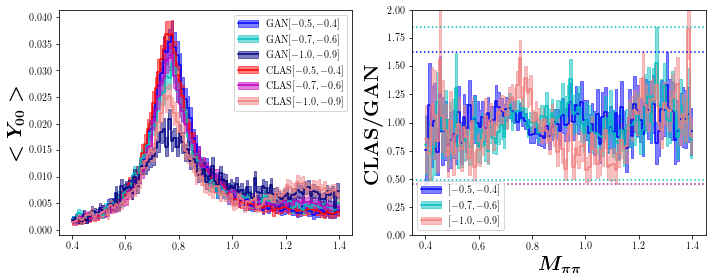

In [88]:
# Makes the comparison plots for these ranges of t calculated in the cell above.
gen_Ylm_plots(0,0, 't')